**кластеризация геометок**

Евгений Борисов esborisov@sevsu.ru

# загружаем данные

In [1]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
display( data.keys() )

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [2]:
print( data['DESCR'] )

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
display( data['frame'].sample(3) )

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20274,3.7480,18.0,6.213000,1.188000,2679.0,2.679000,34.15,-119.23,3.804
5509,1.1985,39.0,3.879022,1.057915,3212.0,4.133848,33.99,-118.41,2.150
12710,2.8000,34.0,4.585657,0.932271,563.0,2.243028,38.59,-121.39,1.136


# обработка геометки

https://geopandas.org/en/stable/getting_started/introduction.html

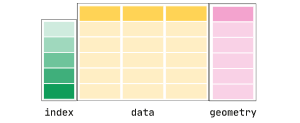

In [4]:
import geopandas as gpd
from shapely.geometry import MultiPoint

In [5]:
gdf = gpd.GeoDataFrame(
        data['frame'],
        geometry=gpd.points_from_xy( data['frame']['Longitude'], data['frame']['Latitude'] ), 
        crs='epsg:4326'
    )

display( len(gdf) )
display( gdf.sample(3) )

20640

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,geometry
11940,2.4435,22.0,4.125370,1.067127,2096.0,2.069102,33.94,-117.41,1.185,POINT (-117.41000 33.94000)
18307,6.4949,32.0,5.662963,1.101852,1267.0,2.346296,37.42,-122.11,4.178,POINT (-122.11000 37.42000)
12007,7.2379,15.0,6.472222,0.940972,1006.0,3.493056,33.91,-117.60,2.510,POINT (-117.60000 33.91000)


In [6]:
del data

# модель кластеризатора

SciKit-Learn : Clustering     
https://scikit-learn.org/stable/modules/clustering.html

In [110]:
%%time 

from sklearn.cluster import KMeans

# кластеризируем геометку

model = KMeans(n_clusters=16).fit(gdf[['Longitude','Latitude']].values )
gdf['cluster'] = model.predict(gdf[['Longitude','Latitude']].values)

CPU times: user 449 ms, sys: 179 ms, total: 628 ms
Wall time: 116 ms


In [111]:
# медиана цены в кластере

cluster_price = (
    gdf[['cluster','MedHouseVal']]
    .groupby(['cluster'])
    ['MedHouseVal'].median()
    .reset_index()
    .rename(columns={'MedHouseVal':'MedHouseVal_cluster'})
)
display( cluster_price.sample(3) )

,cluster,MedHouseVal_cluster
2,2,0.757
4,4,0.810
11,11,0.829


In [112]:
from shapely.geometry import MultiPoint

# границы кластеров на карте
cluster_hull = gpd.GeoDataFrame([
            {
              'cluster': c,
             'geometry': MultiPoint(
                             gdf.query(f'cluster=={c}')['geometry'].to_list()
                         ).convex_hull,
            } for c in sorted(set(gdf['cluster'])) 
        ],crs='epsg:4326'
    )

In [113]:
cluster_hull.merge(
        cluster_price
        ,on=['cluster'] 
    ).explore( column='MedHouseVal_cluster', cmap='coolwarm', legend=False)

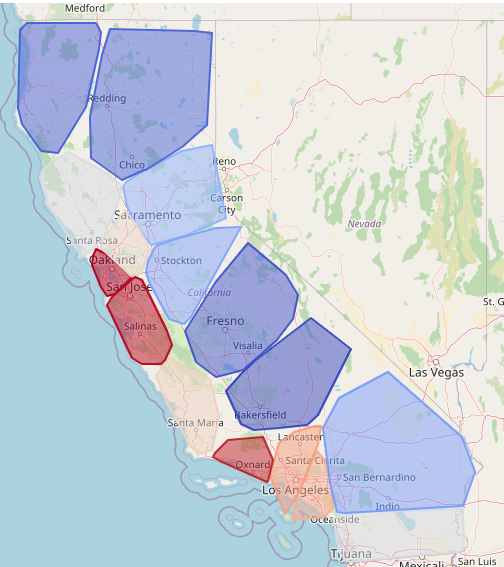

----

In [ ]:
# !pip3 install watermark

In [ ]:
%load_ext watermark
%watermark --python
%watermark --iversions